In [3]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
from sklearn.datasets import make_blobs
from utility import *
import os

# P-Mediana

Soluzione del problema di clustering ottenuta risolvendo all'esatto, tramite il solutore gurobi, il problema di programmazione lineare intera di p-mediana.

Il programma, dopo aver caricato l'istanza di un problema di clustering, calcolate tutte le distanze $d_{i,j}$ tra tutte le coppie di punti, definisce il modello di PLI e procede a risolverlo.

Calcolo delle distanze, necessarie per la definizione del modello di PLI.

In [9]:
dirname = os.path.dirname("__file__")
test = 3
filename = os.path.join(dirname, f'benchmark/benchmark{test}.txt')
points = load_points(filename)
n_clusters = [5,5,5,10,5,10,5,5,5,5,4,5,10,5,5]

K = n_clusters[test-1]
N = len(points)

dist = {}

for i in range(N):
    for j in range(N):
        dist[(i,j)] = np.sum((points[i]-points[j])**2)

# Formulazione del problema

### Variabili

- $y_{i}$ : Variabile binaria che descrive l'utilizzo del punto $i$ come centroide di un cluster.

- $x_{i,j}$: Variabile binaria che determina se il punto $j$ è raggruppato nel cluster con centroide $i$. Queste variabili possono essere in realtà modellate come intera data la totale unimodularità della matrice dei vincoli.
### Funzione obiettivo
Minimizza la distanza di ogni punto dal proprio centroide:

$$
\text{Minimize} \quad  \sum_{i=1}^N\sum_{j=1}^N d_{i,j}x_{i,j} 
$$

### Vincoli
- Esattamente K punti devono essere scelti come centroidi:

$$
  \sum_{i = 1}^N y_{i} = K \quad \quad
$$

- Ogni punto $j$ deve essere connesso ad un centroide:

$$
  \sum_{i = 1}^N x_{i,j} = 1 \quad \quad i \in \{1,2,...,N\}
$$

- Un punto $j$ può essere connesso ad un altro $i$ solo se $i$ è stato scelto come centroide:

$$
  0 \le x_{i,j} \le y_i \quad \quad i,j \in \{1,2,...,N\}
$$

In [6]:
model = gp.Model()
x = model.addVars(N,N, name = "X") #i elemento , j centroide
y = model.addVars(N, vtype = gp.GRB.BINARY, name = "Y")

obj = model.setObjective(x.prod(dist), gp.GRB.MINIMIZE)

model.addConstrs((sum(x[i,j] for j in range(N)) == 1 for i in range(N)))
model.addConstr(sum(y[j] for j in range(N))==K)
model.addConstrs((x[i,j]<=y[j] for i in range(N) for j in range(N)))

model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-01
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 250501 rows, 250500 columns and 750500 nonzeros
Model fingerprint: 0x5edfc58c
Variable types: 250000 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-05, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 1.71s
Presolved: 250501 rows, 250500 columns, 750500 nonzeros
Variable types: 250000 continuous, 500 integer (500 binary)
Found heuristic solution: objective 774.7191716

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   79373    2.8509160e+03   0.000000e+00   3.502337e+06      5s
   97934    1.7297689e+03   0.00

Valutazione della soluzione ottenuta tramite la metrica di squared inner distance e stampa della soluzione

614.4681885487528


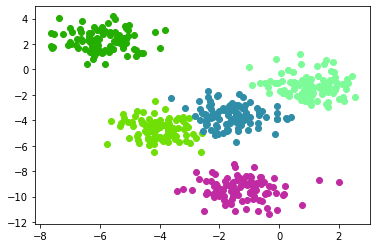

In [7]:
centroids = []
for j in range(N):
    if y[j].X == 1:
        centroids.append(j)

sol = np.zeros(N)

for i in range(N):
    for cluster,j in enumerate(centroids):
        if x[i,j].X == 1:
            sol[i] = cluster


print("{}".format(squared_inner_distance(sol, points, K)))

printR2sol(points, sol, K)